# Overview

The goal of this notebook is to design a machine learning model to predict the salary of a job as best as possible from the information in the job description and to inerpret it afterwards. The procedure was as follows:
- [Test of a baseline](#baseline)
- [Test of a linear model](#linear_model)
- [Test of a non-linear model](#non-linear_model)
- [Interpretation of the results](#interpretation)
- [Summary of the results](#summary)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from category_encoders.target_encoder import TargetEncoder
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data2/cleaned_wide.csv")
df = df.loc[df["title_category"] != "Others"]
df.dropna(subset=["average_salary"], inplace=True)
df.head()

,link,company,title,content,rating,num_ratings,company_link,release_date,company_size,permanent_employment,...,creativity,leadership,flexibility,business_focus,initiative,structured_working,little_experience,much_experience,no_experience_information,some_experience
1,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,...,False,False,False,False,False,False,False,False,True,False
2,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,...,False,False,False,False,False,False,False,False,True,False
3,https://www.stepstone.de/stellenangebote--Data...,METRO Markets GmbH,Data Science Lead,We create the future of B2B commerce by giving...,NaN,NaN,NaN,2022-06-01,NaN,True,...,False,False,True,False,False,False,False,True,False,False
4,https://www.stepstone.de/stellenangebote--Busi...,R+V Allgemeine Versicherung AG,Business Analyst / Data Science (m/w/d),Wie sich die Versicherung von morgen anfühlen ...,4.4,247 Bewertungen,https://www.stepstone.de/cmp/de/R-V-Allgemeine...,2022-06-01,"10,001+",True,...,False,False,False,False,True,False,False,False,True,False
8,https://www.stepstone.de/stellenangebote--Data...,CHECK24,Data Science & Artificial Intelligence Manager...,CHECK24 ist eines der führenden Online-Unterne...,4.5,179 Bewertungen,https://www.stepstone.de/cmp/de/CHECK24-112642...,2022-05-28,2501-5000,True,...,False,True,False,False,False,False,False,False,True,False


In [3]:
df.shape

(1687, 103)

Within the EDA, attributes have already been identified that are not relevant with regard to the salary of a job. These are excluded from the outset during model building.

In [4]:
df = df[["company", "company_size", "home_office_possible", "part_time", "title_category", "experience_level", "average_salary", "main_location", 
         "multiple_locations", "main_region", "main_industry", "master", "phd", "bachelor", "no_degree_info",
         "little_experience", "much_experience", "no_experience_information", "some_experience"]]

In order to achieve an unbiased estimation of the model quality later on, the first step is to split off a part of the data as test data and put it away.

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_train.shape, df_test.shape

((1349, 19), (338, 19))

There are three attributes with missing values. Since all attributes are categorical features, it was decided to add an additional category "missing" later.

In [6]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

company_size                 345
main_industry                217
main_region                   42
no_experience_information      0
much_experience                0
little_experience              0
no_degree_info                 0
bachelor                       0
phd                            0
master                         0
dtype: int64

The target variable is approximately normally distributed, but contains a relatively extreme outlier. When using a linear model, it may be useful to remove this from the training data to better approximate the remaining data points.

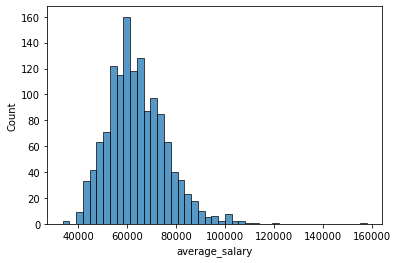

In [30]:
sns.histplot(x=df_train["average_salary"]);

<a id="baseline"></a>

# Baseline

To get a feel for the difficulty of the problem, the first step is to establish a simple baseline performance. In a regression problem, the use of the target mean for all predictions is usually suitable for this purpose.

In [8]:
X = df_train.drop("average_salary", axis=1)
y = df_train["average_salary"]
model = DummyRegressor(strategy="mean")
results = cross_validate(model, X, y, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 9328.610852440717
test score: 9331.5807791647


<a id="linear_model"></a>

# Lineares Modell

During preprocessing, all missing values are first replaced by the missing_value category. Then, all categorical features are converted to numeric features using one-hot encoding. Scaling of the data is not necessary because the dataset contains only categorical features.

In [10]:
X = df_train.drop(["average_salary"], axis=1)
y = df_train["average_salary"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("model", LinearRegression())
])

results = cross_validate(pipe, X, y, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 3119.7781152269595
test score: 7090.917786793207


The linear regression already provides a clear improvement over the baseline. However, the large difference between training and test error suggests that the model overfits the training data. Therefore, the effect of additional regularization will be investigated next.

In [26]:
X = df_train.drop(["average_salary"], axis=1)
y = df_train["average_salary"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("model", Lasso())
])

param_grid = {"model__alpha": list(range(0,50))}
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1)
grid.fit(X, y)

results = pd.DataFrame({"alpha": grid.cv_results_["params"], "train_error": np.abs(grid.cv_results_["mean_train_score"]), "test_error": np.abs(grid.cv_results_["mean_test_score"])})
results.loc[results["test_error"] == results["test_error"].min()]

,alpha,train_error,test_error
9,{'model__alpha': 9},5081.473058,6370.336654


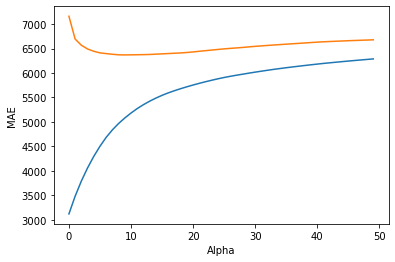

In [29]:
plt.plot(results["train_error"])
plt.plot(results["test_error"])
plt.xlabel("Alpha")
plt.ylabel("MAE");

The benefit of additional regularization leads to a significant improvement in the generalization error at the expense of a higher training error.

In [13]:
X = df_train.drop(["average_salary"], axis=1)
y = df_train["average_salary"]

kfold = KFold(5)
train_error_grid = []
test_error_grid = []
alpha_list = list(range(0,50))

for alpha in tqdm(range(0,50)):
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("model", Lasso(alpha=alpha))
    ])
    train_error = []
    test_error = []
    for train, test in kfold.split(X, y):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_train = X_train.loc[y_train<120000]
        y_train = y_train.loc[y_train<120000]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        pipe.fit(X_train, y_train)
        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)
        train_error.append(mean_absolute_error(y_train, y_pred_train))
        test_error.append(mean_absolute_error(y_test, y_pred_test))

    train_error_grid.append(np.mean(train_error))
    test_error_grid.append(np.mean(test_error))
    pipe.fit(X,y)

results = pd.DataFrame({"alpha": alpha_list, "train_error": train_error_grid, "test_error": test_error_grid})
results.loc[results["test_error"] == results["test_error"].min()]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:55<00:00,  2.31s/it]


,alpha,train_error,test_error
9,9,5071.690649,6356.108675


Removing the outlier once again brings a slight improvement on the test data, as the large mass of data points can now be displayed a little better.

<a id="non-linear_model"></a>

# Nichtlineares Modell

In [14]:
X = df_train.drop(["average_salary"], axis=1)
y = df_train["average_salary"]

onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

target_encoding = TargetEncoder()

pipe = Pipeline([
    ("encoder", None),
    ("model", XGBRegressor(random_state=0))
])

param_grid = {"encoder": [onehot_encoding, target_encoding],
              "model__n_estimators": [50, 100, 200, 500, 1000], 
              "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
              "model__max_depth": [5, 6, 7],
              "model__subsample": [0.5, 0.7, 0.9, 1],
              "model__colsample_bylevel": [0.5, 0.7, 0.9, 1],
              "model__reg_lambda": [0, 1, 3, 5, 10],
              "model__reg_alpha": [0, 1, 3, 5, 10],
              "model__gamma": [0, 1, 3, 5, 10]}
grid = RandomizedSearchCV(pipe, param_grid, n_iter=100, scoring="neg_mean_absolute_error", return_train_score=True, verbose=1, n_jobs=-1, random_state=0)
grid.fit(X, y)

print(np.abs(grid.best_score_))
grid.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
6327.943518873486


Pipeline(steps=[('encoder',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value='missing_value',
                                                strategy='constant')),
                                 ('encoder',
                                  OneHotEncoder(handle_unknown='ignore'))])),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=0.7, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=Fals...
                              gamma=5, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.05, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0,

A nonlinear model produced only a slight improvement over the linear model. With a GridSearch, it might have been possible to find a slightly better hyperparameter combination. In addition, other gradient boosting variants such as LightGBM or CatBoost could perform even minimally better. However, since the results so far do not suggest that a nonlinear model adds much value in this scenario, further tuning is foregone in favor of performance.

On the other hand, the linear model provides shorter computation & inference times, lower memory requirements, and better interpretability. Therefore, the linear model was chosen for this scenario.

<a id="interpretation"></a>

# Interpretation

In [15]:
X_train = df_train.drop(["average_salary"], axis=1)
y_train = df_train["average_salary"]
X_test = df_test.drop(["average_salary"], axis=1)
y_test = df_test["average_salary"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("model", Lasso(alpha=9))
])

X_train = X_train.loc[y_train<120000]
y_train = y_train.loc[y_train<120000]
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
print(f"Mean Absolute Error on Test Set: {mean_absolute_error(y_test, predictions)}")

Mean Absolute Error on Test Set: 7190.746562402096


The error on the test data is significantly higher than the cross validation score. This is an indication that the variance of the error is very large due to the small samples. For more precise statements about the quality of such a model, one would need significantly more data.

Next, the coefficients of the model are to be interpreted. The OneHotEncoder of Scikit-Learn makes it relatively cumbersome to extract the names of the coded features. Therefore, the pipeline is slightly modified in the following and the Pandas method get_dummies() is used instead, which leads to the same results, but chooses the names of the features better.

In [16]:
X_train = df_train.drop(["average_salary"], axis=1)
y_train = df_train["average_salary"]
X_train = pd.get_dummies(X_train, dummy_na=True)

model = Lasso(alpha=9)

results = cross_validate(model, X_train, y_train, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 5081.473503136437
test score: 6370.539425477728


In [17]:
X_train = X_train.loc[y_train<120000]
y_train = y_train.loc[y_train<120000]
model.fit(X_train, y_train)
importances = pd.DataFrame({"feature": X_train.columns, "coefficient": model.coef_})
importances.sort_values("coefficient", ascending=False, key=lambda x: np.abs(x)).head(10)

,feature,coefficient
262,company_JLL,33766.034251
116,company_Cofinpro AG,23770.464119
88,company_Biotronik SE & Co. KG,20589.172679
497,company_Wall GmbH,16673.274421
186,company_GE Aviation,16571.173702
377,company_Ratbacher GmbH,16072.569748
419,company_Siemens AG,14697.750559
119,company_Condo Group GmbH,-14476.741017
398,company_STRATO Customer Service GmbH,-14215.481134
461,company_Temedica GmbH,13655.342143


A first overview shows that the largest coefficients of the model are mainly specific company names. While it is certainly interesting to know which companies pay the highest salaries, this analysis will focus primarily on somewhat more general factors. Therefore, all company names and city names are left out in the following.

In [18]:
importances.loc[~importances["feature"].str.contains("company|main_location")].sort_values("coefficient", ascending=False).head(10)

,feature,coefficient
830,main_industry_Medizintechnik,6527.301626
602,experience_level_Senior,4006.961666
595,title_category_Data Science Manager,3907.909424
799,main_region_Hesse,3720.556975
808,main_region_nan,3439.558877
810,main_industry_Banken,2904.985586
828,main_industry_Maschinen- und Anlagenbau,2901.724841
8,much_experience,2892.301743
596,title_category_Data Scientist,2881.494522
842,main_industry_Versicherungen,2462.262544


In certain industries, such as medicine, engineering or banking, particularly high salaries are paid. In addition, positions where more experience is required pay better than others.

In [19]:
importances.loc[~importances["feature"].str.contains("company|main_location")].sort_values("coefficient", ascending=True).head(10)

,feature,coefficient
600,experience_level_Junior,-9280.859660
592,title_category_Data Analyst,-4404.333204
840,main_industry_Transport & Logistik,-3928.854085
803,main_region_Saarland,-3755.609521
598,title_category_Software Engineer,-3537.064664
804,main_region_Saxony,-3043.637931
818,"main_industry_Freizeit, Touristik, Kultur & Sport",-2810.086057
845,main_industry_nan,-2612.309733
835,main_industry_Sonstige Branchen,-2181.772505
594,title_category_Data Science Consultant,-2174.963452


As expected, the lowest salaries are paid in junior level positions. It is also evident that particularly low salaries are paid in Saarland. However, this coefficient may also be the result of the very small sample for this state. Furthermore, it becomes clear that certain job titles are also paid significantly less than others on average.

In the following, individual related categories will be discussed in more detail.

In [20]:
importances.loc[importances["feature"].str.contains("title_category_")].sort_values("coefficient", ascending=False)

,feature,coefficient
595,title_category_Data Science Manager,3907.909424
596,title_category_Data Scientist,2881.494522
593,title_category_Data Engineer,0.000000
597,title_category_Machine Learning Engineer,0.000000
599,title_category_nan,0.000000
594,title_category_Data Science Consultant,-2174.963452
598,title_category_Software Engineer,-3537.064664
592,title_category_Data Analyst,-4404.333204


There are sometimes strong differences between the individual job titles, as already became clear during the EDA.

In [21]:
importances.loc[importances["feature"].str.contains("experience_level_")].sort_values("coefficient", ascending=False)

,feature,coefficient
602,experience_level_Senior,4006.961666
601,experience_level_No Information,0.000000
603,experience_level_nan,0.000000
600,experience_level_Junior,-9280.859660


Even with the required experience level of a position, the coefficients obtained are as could be expected.

In [22]:
importances.loc[importances["feature"].str.contains("_experience")].sort_values("coefficient", ascending=False)

,feature,coefficient
8,much_experience,2892.301743
10,some_experience,719.569279
9,no_experience_information,-1315.187991
7,little_experience,-1616.563572


The greater the professional experience required, the higher the pay.

In [23]:
importances.loc[importances["feature"].str.contains("master|phd|bachelor|no_degree_info")].sort_values("coefficient", ascending=False)

,feature,coefficient
4,phd,1275.416467
3,master,528.536099
5,bachelor,0.000000
6,no_degree_info,-558.848365


The higher the required degree, the higher the payment. During the extraction of the corresponding information in the course of preprocessing, it was not yet entirely clear whether, in the case of a missing specification, no financial statement was required or the specification was merely forgotten. The negative coefficient makes it clear that, in these cases, a financial statement is probably really not required.

In [24]:
importances.loc[importances["feature"].str.contains("company_size_")].sort_values("coefficient", ascending=False)

,feature,coefficient
584,"company_size_10,001+",4424.074560
588,"company_size_5001-10,000",3476.460542
591,company_size_nan,1597.320375
586,company_size_2501-5000,1425.311507
589,company_size_501-1000,-0.000000
585,company_size_1001-2500,-111.926836
587,company_size_251-500,-1359.178346
583,company_size_0-50,-1573.538280
590,company_size_51-250,-2640.527077


On the whole, the trend that larger companies also pay higher salaries is confirmed. In the context of the EDA, it still looked as if the company size 1001-2500 paid worse salaries on average than significantly smaller companies. However, this effect was obviously based on other factors and is clearly relativized in the multivariate analysis. It is also interesting that the negative coefficient of the smallest company size is significantly lower than that of the second smallest. This may indicate that employees in very small companies may have to take on several tasks at the same time and work longer hours to compensate for the lack of employees, but are compensated somewhat better for this.

In [25]:
importances.loc[importances["feature"].str.contains("main_region_")].sort_values("coefficient", ascending=False)

,feature,coefficient
799,main_region_Hesse,3720.556975
808,main_region_nan,3439.558877
794,main_region_Baden-Württemberg,2391.647652
798,main_region_Hamburg,1546.747797
796,main_region_Berlin,1190.787430
807,main_region_Thuringia,864.197659
795,main_region_Bavaria,686.816497
797,main_region_Brandenburg,-0.000000
800,main_region_Lower Saxony,-0.000000
802,main_region_Rhineland-Palatinate,-0.000000


It is striking that Bavaria, which had the second highest value in the EDA, has only a comparatively low positive coefficient in the multivariate analysis. However, this may also be due to the fact that a large part of this positive relationship is already integrated with cities such as Munich. The EDA has shown that adding the individual cities to the model is necessary. However, this introduces a certain degree of multicolinearity into the model, which makes the interpretation of the coefficients more difficult.

<a id="summary"></a>

# Summary

With the model found, it was possible to reduce the mean error of salary forecasts by 3000 euros. Nevertheless, the remaining error is still more than 6000 euros. All the features that Stepstone includes in its description of its machine learning model were also included in this model. The rules for extracting job titles, different skills, or work experience were made to the best of our ability. However, it is quite possible that Stepstone used a slightly different approach when extracting this information and may have evaluated other keywords as well. From the location information, only the states were additionally extracted in the context of this model with the help of an API. Here, one could possibly include other features such as population figures of the cities. 

The most likely reason for the poorer results is the insufficient amount of data. In the context of the EDA it became clear that some relationships to the target are still very distorted due to the too small sample (e.g. highest average salary in Thuringia). Most of the relationships in the model make sense in principle, but are still relatively subject to noise. For example, there is no monotonic dependence between salary and company size in the data used. A larger data set would help to minimize this noise in the data and better represent the true relationships. Also, the error obtained on the test data is relatively imprecise at the moment and would also benefit from a larger data set.

Finally, it should also be mentioned that the values of the target are also in the predictions of a model and not real salaries. Attributes with Python, R or SQL, which hardly make a difference in the context of this analysis, could possibly be important for an analysis specifically designed for Data Science jobs.